In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

torch.manual_seed(42)

# Introduction to Generative Models and Latent Variable Models

<span style="font-size: 15px;">

Having covered the fundamentals of neural networks in PyTorch, feedforward networks, loss functions, optimizers, convolutional and recurrent layers (see the companion repository `learning-neural-networks-with-pytorch`), we now turn to our first proper **generative model**. Most generative models can be classified as **Latent Variable Models (LVMs)**, which is essentially a framework for unsupervised learning.

**What is a Latent Variable Model?**

A latent variable model posits that the observed data $x$ is generated from some underlying **latent** (hidden) variables $z$ that capture the essential structure of the data. The term "latent" comes from Latin *latēre* meaning "to lie hidden", these variables are never directly observed but are inferred from the data.

**Common generative models that fall under the LVM framework:**

| Model | Latent Space Dimension | Encoding Process | Decoding Process |
|-------|------------------------|------------------|------------------|
| **Autoencoder** | $\dim(z) < \dim(x)$ | Neural network compression | Neural network reconstruction |
| **Variational Autoencoder (VAE)** | $\dim(z) < \dim(x)$ | Probabilistic encoding | Probabilistic decoding |
| **Diffusion Model** | $\dim(z) = \dim(x)$ | Sequential noise addition | Sequential denoising |
| **Transformer (for generation)** | Contextual embeddings | Self-attention encoding | Autoregressive decoding |

Despite their seemingly different architectures, all these models share a common structure:

$$
\boxed{\text{Input } x \xrightarrow{\text{Encoder}} \text{Latent Space } z \xrightarrow{\text{Decoder}} \text{Output } \hat{x}}
$$

**The Three Stages of a Latent Variable Model**

1. **Encoding Process**: Maps the high-dimensional input $x \in \mathbb{R}^{D_x}$ to a (typically) lower-dimensional latent representation $z \in \mathbb{R}^{D_z}$

2. **Latent Space**: The compressed representation that captures the essential features of the data. This is where the "magic" happen, the model learns to represent complex, high-level features in a compact form.

3. **Decoding Process**: Maps from the latent space back to the original data space, producing a reconstruction $\hat{x} \in \mathbb{R}^{D_x}$

The **information bottleneck** created by having $D_z < D_x$ forces the model to learn the most salient features of the data, discarding irrelevant details.

</span>

<span style="font-size: 15px;">
    
**Explicit vs. Implicit Latent Variable Models**

Latent variable models can be further categorized:

- **Explicit LVMs**: The latent representation is encoded as concrete numerical vectors/tensors that can be directly inspected and manipulated. Examples: Autoencoders, VAEs, Diffusion Models.

- **Implicit LVMs**: The latent structure is not encoded in a single tensor but is implicitly learned through the model's behavior. Example: Generative Adversarial Networks (GANs).
</span>

## Autoencoder

### Conceptual Overview

<span style="font-size: 15px;">

The **autoencoder** is the simplest and purest form of a latent variable model. Importantly, a standard autoencoder is **not technically a generative model**, it cannot generate new samples. Instead, it learns a compressed representation of its inputs, making it a stepping stone toward true generative models like the Variational Autoencoder (VAE).

An autoencoder consists of two neural networks:

1. **Encoder** $E_\phi$: Compresses the input $x$ into a latent vector $z$
2. **Decoder** $D_\theta$: Reconstructs the input from the latent vector, producing $\hat{x}$

The architecture is intentionally symmetric:

$$
\begin{aligned}
z &= E_\phi(x) \quad &\text{(encoding)}\\
\hat{x} &= D_\theta(z) = D_\theta(E_\phi(x)) \quad &\text{(decoding/reconstruction)}
\end{aligned}
$$

where $\phi$ and $\theta$ denote the learnable parameters (weights and biases) of the encoder and decoder networks, respectively.

**The Information Bottleneck**

The key insight of autoencoders is the **information bottleneck**: by forcing $\dim(z) < \dim(x)$, we constrain the network to learn a compressed representation that captures only the most important features.

For example, if we have:
- Input image: $x \in \mathbb{R}^{28 \times 28} = \mathbb{R}^{784}$ (e.g., MNIST digit)
- Latent space: $z \in \mathbb{R}^{32}$

The encoder must learn to compress 784 dimensions into just 32, forcing it to discover the underlying structure of digits (curves, lines, orientations) rather than memorizing pixel values.

</span>

### Mathematical Formulation

<span style="font-size: 15px;">

**Encoder Network**

The encoder maps from the input space to the latent space. For a simple feedforward encoder with $L$ layers, we have:

$$
\begin{aligned}
h^{(0)} &= x \\
h^{(\ell)} &= \sigma\left( W^{(\ell)}_E h^{(\ell-1)} + b^{(\ell)}_E \right) \quad \text{for } \ell = 1, \ldots, L-1 \\
z &= W^{(L)}_E h^{(L-1)} + b^{(L)}_E
\end{aligned}
$$

where:
- $W^{(\ell)}_E \in \mathbb{R}^{d_{\ell} \times d_{\ell-1}}$ are the encoder weight matrices
- $b^{(\ell)}_E \in \mathbb{R}^{d_{\ell}}$ are the encoder bias vectors
- $\sigma$ is a nonlinear activation function (e.g., ReLU)
- $d_0 = D_x$ (input dimension), $d_L = D_z$ (latent dimension)

The layer dimensions typically decrease: $d_0 > d_1 > \cdots > d_L$, creating the compression.

**Decoder Network**

The decoder is the mirror image of the encoder, mapping from latent space back to input space:

$$
\begin{aligned}
g^{(0)} &= z \\
g^{(\ell)} &= \sigma\left( W^{(\ell)}_D g^{(\ell-1)} + b^{(\ell)}_D \right) \quad \text{for } \ell = 1, \ldots, L-1 \\
\hat{x} &= \sigma_{\text{out}}\left( W^{(L)}_D g^{(L-1)} + b^{(L)}_D \right)
\end{aligned}
$$

where:
- $W^{(\ell)}_D \in \mathbb{R}^{d_{\ell} \times d_{\ell-1}}$ are the decoder weight matrices
- $b^{(\ell)}_D \in \mathbb{R}^{d_{\ell}}$ are the decoder bias vectors
- $\sigma$ is a nonlinear activation function (e.g., ReLU)
- $d_0 = D_z$ (latent dimension), $d_L = D_x$ (output dimension)
- The value of $L$ appearing in the decoder **is not necessarily** the same as in the encoder.

The layer dimensions typically increase: $d_0 < d_1 < \cdots < d_L$, creating the decompression. It is important to mention, that the decoding network **does not have to be** the same as the inverse of the encoding network.

**Reconstruction Loss**

The autoencoder is trained in a purely **unsupervised** manner, i.e., no labels are required. The objective is to minimize the **reconstruction loss** between the input and its reconstruction:

$$
\mathcal{L}_{\text{recon}}(\phi, \theta) = \frac{1}{N} \sum_{b=0}^{N-1} \left\| x^{(b)} - \hat{x}^{(b)} \right\|^2 = \frac{1}{N} \sum_{b=0}^{N-1} \left\| x^{(b)} - D_\theta(E_\phi(x^{(b)})) \right\|^2
$$

This is simply the Mean Squared Error (MSE) between inputs and reconstructions (see `LossFunctions.ipynb` in the companion repository for details on MSE).

**Remark**: For image data with pixel values in $[0, 1]$, Binary Cross-Entropy (BCE) loss is also commonly used:

$$
\mathcal{L}_{\text{BCE}}(\phi, \theta) = -\frac{1}{N \cdot D_x} \sum_{b=0}^{N-1} \sum_{i=0}^{D_x-1} \left[ x^{(b)}_i \log(\hat{x}^{(b)}_i) + (1 - x^{(b)}_i) \log(1 - \hat{x}^{(b)}_i) \right]
$$

</span>

### Autoencoder in PyTorch

<span style="font-size: 15px;">

We now implement an autoencoder in PyTorch. The structure follows the standard pattern of subclassing `nn.Module` (see `Layers.ipynb` for details on PyTorch layers).

**Architecture Parameters**

Our autoencoder takes two key parameters:
- `input_dim`: The dimension $D_x$ of the flattened input (e.g., $28 \times 28 = 784$ for MNIST)
- `latent_dim`: The dimension $D_z$ of the latent space (the bottleneck)

</span>

#### Building an Autoencoder NN

In [2]:
class Autoencoder(nn.Module):
    """
    A simple feedforward autoencoder.
    
    Architecture:
        Encoder: input_dim -> 256 -> 128 -> latent_dim
        Decoder: latent_dim -> 128 -> 256 -> input_dim
    """
    
    def __init__(self, input_dim: int, latent_dim: int):
        super().__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: Compresses input_dim -> latent_dim
        # Note the decreasing dimensions: input_dim > 256 > 128 > latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
            # No activation on latent space - we want unbounded representations
        )
        
        # Decoder: Reconstructs latent_dim -> input_dim
        # Mirror architecture: latent_dim < 128 < 256 < input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # Output in [0, 1] for normalized pixel values
        )
    
    def encode(self, x):
        """Encode input to latent representation: x -> z"""
        return self.encoder(x)
    
    def decode(self, z):
        """Decode latent representation to reconstruction: z -> x_hat"""
        return self.decoder(z)
    
    def forward(self, x):
        """
        Full forward pass: x -> z -> x_hat
        
        Returns both the latent vector and reconstruction for flexibility.
        """
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

In [3]:
# Let's verify the architecture and parameter counts
input_dim = 784   # 28 x 28 MNIST images
latent_dim = 32   # Compress to 32 dimensions

model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)

print("Autoencoder Architecture")
print("=" * 60)
print(f"Input dimension:  D_x = {input_dim}")
print(f"Latent dimension: D_z = {latent_dim}")
print(f"Compression ratio: {input_dim / latent_dim:.1f}x")
print()
print("Encoder:")
print(model.encoder)
print()
print("Decoder:")
print(model.decoder)

Autoencoder Architecture
Input dimension:  D_x = 784
Latent dimension: D_z = 32
Compression ratio: 24.5x

Encoder:
Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
)

Decoder:
Sequential(
  (0): Linear(in_features=32, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Sigmoid()
)


In [8]:
# Count parameters in each component
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

encoder_params = count_parameters(model.encoder)
decoder_params = count_parameters(model.decoder)
total_params = count_parameters(model)

print("\nParameter Count")
print("=" * 60)
print(f"Encoder parameters: {encoder_params:,}")
print(f"Decoder parameters: {decoder_params:,}")
print(f"Total parameters:   {total_params:,}")
print()


Parameter Count
Encoder parameters: 237,984
Decoder parameters: 238,736
Total parameters:   476,720



In [9]:
# Test forward pass with random input
batch_size = 16
x = torch.randn(batch_size, input_dim)

# Forward pass
x_hat, z = model(x)

print("Forward Pass Verification")
print("=" * 60)
print(f"Input shape:          x.shape = {tuple(x.shape)} → (B={batch_size}, D_x={input_dim})")
print(f"Latent shape:         z.shape = {tuple(z.shape)} → (B={batch_size}, D_z={latent_dim})")
print(f"Reconstruction shape: x_hat.shape = {tuple(x_hat.shape)} → (B={batch_size}, D_x={input_dim})")
print()
print(f"Reconstruction values in [0, 1]: min={x_hat.min().item():.4f}, max={x_hat.max().item():.4f}")

Forward Pass Verification
Input shape:          x.shape = (16, 784) → (B=16, D_x=784)
Latent shape:         z.shape = (16, 32) → (B=16, D_z=32)
Reconstruction shape: x_hat.shape = (16, 784) → (B=16, D_x=784)

Reconstruction values in [0, 1]: min=0.4635, max=0.5366


##### **Possible Extension to a Convolutional Autoencoder**

<span style="font-size: 15px;">

For image data, using convolutional layers (see `Layers.ipynb` for details on `nn.Conv2d` and `nn.ConvTranspose2d`) is more appropriate than fully connected layers. The convolutional autoencoder preserves spatial structure and uses fewer parameters.

</span>

In [23]:
class ConvAutoencoder(nn.Module):
    """
    Convolutional autoencoder for image data.
    
    Architecture:
        Encoder: Conv2d layers with stride=2 for downsampling
        Decoder: ConvTranspose2d layers for upsampling
    
    For MNIST (28x28):
        Encoder: (1, 28, 28) -> (16, 14, 14) -> (32, 7, 7) -> flatten -> latent_dim
        Decoder: latent_dim -> unflatten -> (32, 7, 7) -> (16, 14, 14) -> (1, 28, 28)
    """
    
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder: (B, 1, 28, 28) -> (B, latent_dim)
        self.encoder_conv = nn.Sequential(
            # (1, 28, 28) -> (16, 14, 14)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # (16, 14, 14) -> (32, 7, 7)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Flatten: 32 * 7 * 7 = 1568 -> latent_dim
        self.encoder_fc = nn.Linear(32 * 7 * 7, latent_dim)
        
        # Decoder: (B, latent_dim) -> (B, 1, 28, 28)
        self.decoder_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            # (32, 7, 7) -> (16, 14, 14)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # (16, 14, 14) -> (1, 28, 28)
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        # x: (B, 1, 28, 28)
        h = self.encoder_conv(x)  # (B, 32, 7, 7)
        h = h.view(h.size(0), -1)  # (B, 1568)
        z = self.encoder_fc(h)     # (B, latent_dim)
        return z
    
    def decode(self, z):
        # z: (B, latent_dim)
        h = self.decoder_fc(z)            # (B, 1568)
        h = h.view(h.size(0), 32, 7, 7)   # (B, 32, 7, 7)
        x_hat = self.decoder_conv(h)      # (B, 1, 28, 28)
        return x_hat
    
    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

# Test the convolutional autoencoder
conv_ae = ConvAutoencoder(latent_dim=32)
test_input = torch.randn(4, 1, 28, 28)
test_output, test_z = conv_ae(test_input)

print("Convolutional Autoencoder")
print("=" * 60)
print(f"Input shape:  {tuple(test_input.shape)}")
print(f"Latent shape: {tuple(test_z.shape)}")
print(f"Output shape: {tuple(test_output.shape)}")
print(f"\nTotal parameters: {count_parameters(conv_ae):,}")

Convolutional Autoencoder
Input shape:  (4, 1, 28, 28)
Latent shape: (4, 32)
Output shape: (4, 1, 28, 28)

Total parameters: 111,521


#### Training the Autoencoder

<span style="font-size: 15px;">

**Training Loop Overview**

The training loop for an autoencoder follows the standard PyTorch pattern (see `Optimizers.ipynb` and `TransformsAndDataLoader.ipynb` for details on optimizers and data loading):

1. **Forward pass**: Compute reconstruction $\hat{x} = D_\theta(E_\phi(x))$
2. **Compute loss**: $\mathcal{L} = \|x - \hat{x}\|^2$ (MSE) or BCE
3. **Backward pass**: Compute gradients $\nabla_\phi \mathcal{L}$ and $\nabla_\theta \mathcal{L}$
4. **Update parameters**: $\phi \leftarrow \phi - \gamma \nabla_\phi \mathcal{L},~ \theta \leftarrow \theta - \gamma \nabla_\theta \mathcal{L}$
~
The key difference from supervised learning: **we use the input itself as the target**. There are no external labels.

</span>

In [10]:
# Transform: Convert to tensor and normalize to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to tensor and scales to [0, 1]
])

# Load MNIST dataset

# Download and load training data
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create DataLoaders
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Training batches per epoch: {len(train_loader)}")

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:09<00:00, 1.10MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 210kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 1.67MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.51MB/s]

Training samples: 60000
Test samples: 10000
Batch size: 128
Training batches per epoch: 469


In [14]:
for j, i in enumerate(train_loader):
    if j <2:
        print(type(i))
        print(i[0].shape)
        print(i[1].shape)
        print()
    else:
        break

<class 'list'>
torch.Size([128, 1, 28, 28])
torch.Size([128])

<class 'list'>
torch.Size([128, 1, 28, 28])
torch.Size([128])



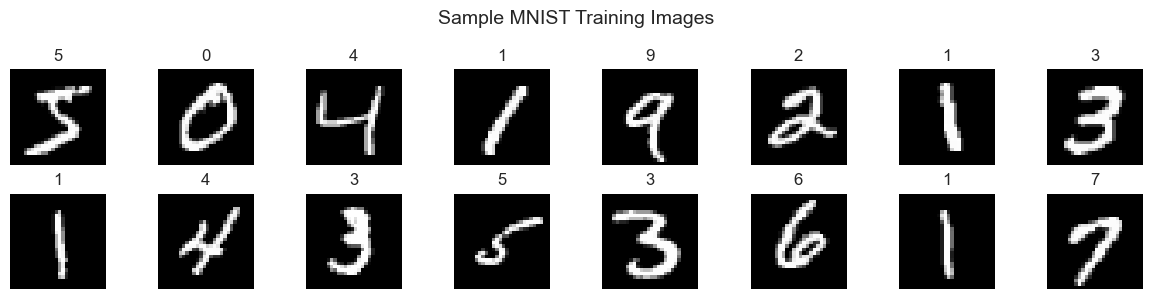

In [11]:
# Visualize some training samples
fig, axes = plt.subplots(2, 8, figsize=(12, 3))

for i in range(16):
    ax = axes[i // 8, i % 8]
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'{label}')
    ax.axis('off')

plt.suptitle('Sample MNIST Training Images', fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
def train_autoencoder(model, train_loader, test_loader, n_epochs, learning_rate, device='cpu'):
    """
    Train an autoencoder with the reconstruction objective.
    
    Parameters:
    -----------
    model : nn.Module
        The autoencoder model
    train_loader : DataLoader
        Training data loader
    test_loader : DataLoader
        Test data loader for evaluation
    n_epochs : int
        Number of training epochs
    learning_rate : float
        Learning rate γ for the optimizer
    device : str
        Device to train on ('cpu' or 'cuda')
    
    Returns:
    --------
    train_losses, test_losses : lists of losses per epoch
    """
    model = model.to(device)
    
    # Reconstruction loss: MSE between input and reconstruction
    criterion = nn.MSELoss()
    
    # Adam optimizer (see Optimizers.ipynb for details)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        # ============ Training Phase ============
        model.train()
        epoch_train_loss = 0.0
        
        for batch_x, _ in train_loader:  # Note: we ignore labels (unsupervised)
            # Flatten images: (B, 1, 28, 28) -> (B, 784)
            batch_x = batch_x.view(batch_x.size(0), -1).to(device)
            
            # Forward pass: x -> z -> x_hat
            x_hat, z = model(batch_x)
            
            # Compute reconstruction loss: L = ||x - x_hat||^2
            loss = criterion(x_hat, batch_x)  # Target is the input itself!
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * batch_x.size(0)
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # ============ Evaluation Phase ============
        model.eval()
        epoch_test_loss = 0.0
        
        with torch.no_grad():
            for batch_x, _ in test_loader:
                batch_x = batch_x.view(batch_x.size(0), -1).to(device)
                x_hat, z = model(batch_x)
                loss = criterion(x_hat, batch_x)
                epoch_test_loss += loss.item() * batch_x.size(0)
        
        epoch_test_loss /= len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        
        # Print progress
        print(f"Epoch [{epoch+1}/{n_epochs}] "
              f"Train Loss: {epoch_train_loss:.6f} | "
              f"Test Loss: {epoch_test_loss:.6f}")
    
    return train_losses, test_losses

In [17]:
# Initialize and train the autoencoder
input_dim = 784
latent_dim = 32
n_epochs = 20
learning_rate = 1e-3

# Check for GPU availability
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Training on: {device}")

# Create model
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Train
print("\nTraining Autoencoder")
print("=" * 60)
train_losses, test_losses = train_autoencoder(
    autoencoder, train_loader, test_loader,
    n_epochs=n_epochs, learning_rate=learning_rate, device=device
)

Training on: mps

Training Autoencoder
Epoch [1/20] Train Loss: 0.049953 | Test Loss: 0.027282
Epoch [2/20] Train Loss: 0.023374 | Test Loss: 0.019636
Epoch [3/20] Train Loss: 0.018075 | Test Loss: 0.015982
Epoch [4/20] Train Loss: 0.014972 | Test Loss: 0.013504
Epoch [5/20] Train Loss: 0.013061 | Test Loss: 0.011994
Epoch [6/20] Train Loss: 0.011583 | Test Loss: 0.010798
Epoch [7/20] Train Loss: 0.010458 | Test Loss: 0.009848
Epoch [8/20] Train Loss: 0.009631 | Test Loss: 0.009255
Epoch [9/20] Train Loss: 0.009012 | Test Loss: 0.008645
Epoch [10/20] Train Loss: 0.008567 | Test Loss: 0.008255
Epoch [11/20] Train Loss: 0.008203 | Test Loss: 0.008045
Epoch [12/20] Train Loss: 0.007885 | Test Loss: 0.007785
Epoch [13/20] Train Loss: 0.007611 | Test Loss: 0.007538
Epoch [14/20] Train Loss: 0.007341 | Test Loss: 0.007277
Epoch [15/20] Train Loss: 0.007122 | Test Loss: 0.007036
Epoch [16/20] Train Loss: 0.006944 | Test Loss: 0.006872
Epoch [17/20] Train Loss: 0.006760 | Test Loss: 0.006695
E

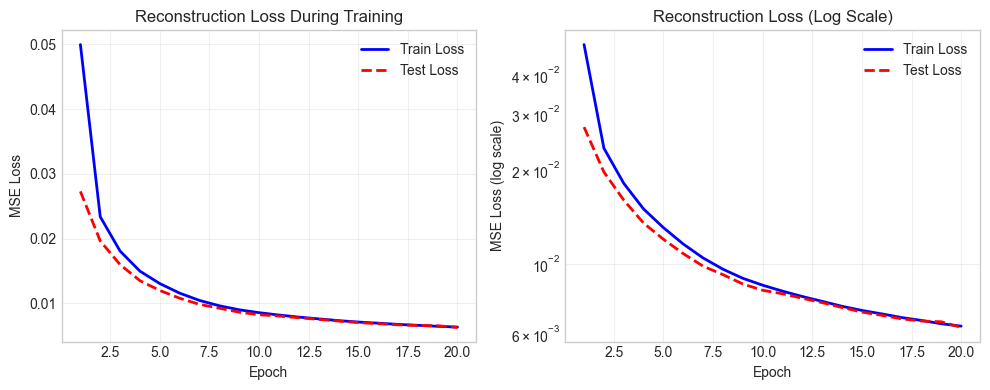

In [18]:
# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(range(1, n_epochs + 1), test_losses, 'r--', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Reconstruction Loss During Training')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(range(1, n_epochs + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.semilogy(range(1, n_epochs + 1), test_losses, 'r--', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Reconstruction Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Visualizing Reconstructions**
<span style="font-size: 15px;">

Now that the autoencoder is trained, let's visualize how well it reconstructs test images. Remember, the autoencoder has never seen these test images during training.

</span>

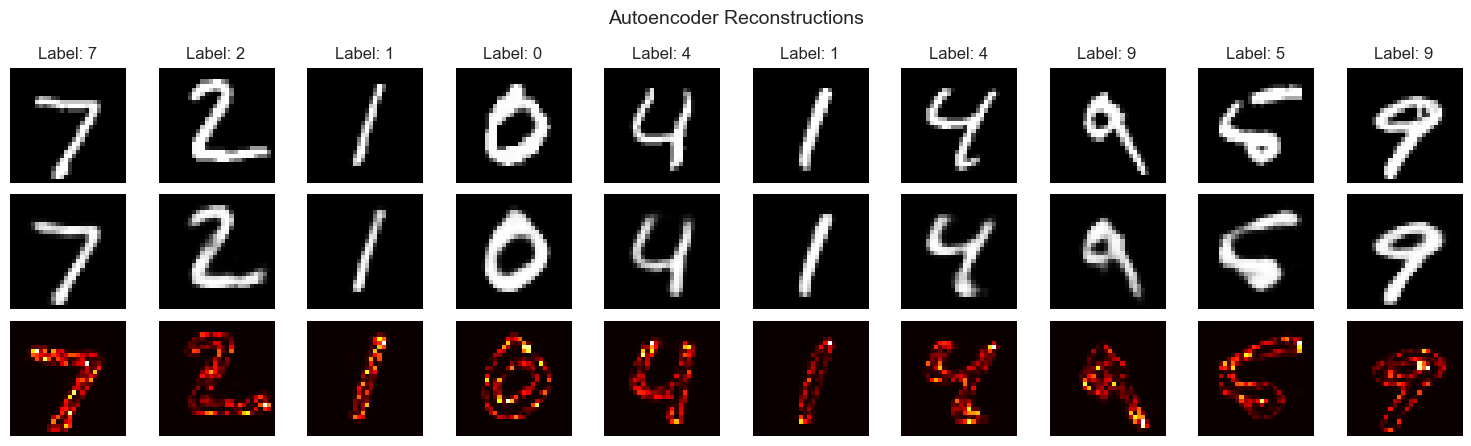

In [19]:
def visualize_reconstructions(model, test_loader, n_images=10, device='cpu'):
    """
    Visualize original images and their reconstructions.
    """
    model.eval()
    model = model.to(device)
    
    # Get a batch of test images
    images, labels = next(iter(test_loader))
    images = images[:n_images]
    labels = labels[:n_images]
    
    # Flatten and reconstruct
    with torch.no_grad():
        flat_images = images.view(n_images, -1).to(device)
        reconstructions, latent = model(flat_images)
        reconstructions = reconstructions.cpu().view(n_images, 1, 28, 28)
    
    # Plot
    fig, axes = plt.subplots(3, n_images, figsize=(n_images * 1.5, 4.5))
    
    for i in range(n_images):
        # Original
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Label: {labels[i].item()}')
        axes[0, i].axis('off')
        
        # Reconstruction
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        
        # Difference (error)
        diff = torch.abs(images[i] - reconstructions[i])
        axes[2, i].imshow(diff.squeeze(), cmap='hot')
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel('Original', fontsize=12)
    axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
    axes[2, 0].set_ylabel('|Error|', fontsize=12)
    
    plt.suptitle('Autoencoder Reconstructions', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_reconstructions(autoencoder, test_loader, n_images=10, device=device)

#### Exploring the Latent Space

<span style="font-size: 15px;">

One of the main utilities of an autoencoder is the learned latent representation. Once trained, we can discard the decoder and use only the encoder to obtain compressed representations of new inputs. These representations can be used for:

1. **Dimensionality reduction**: Visualize high-dimensional data in 2D/3D
2. **Clustering**: Group similar inputs based on their latent representations
3. **Feature extraction**: Use latent vectors as input features for downstream tasks
4. **Anomaly detection**: Unusual inputs will have unusual latent representations

</span>

Applying t-SNE to 3000 latent vectors of dimension 32...


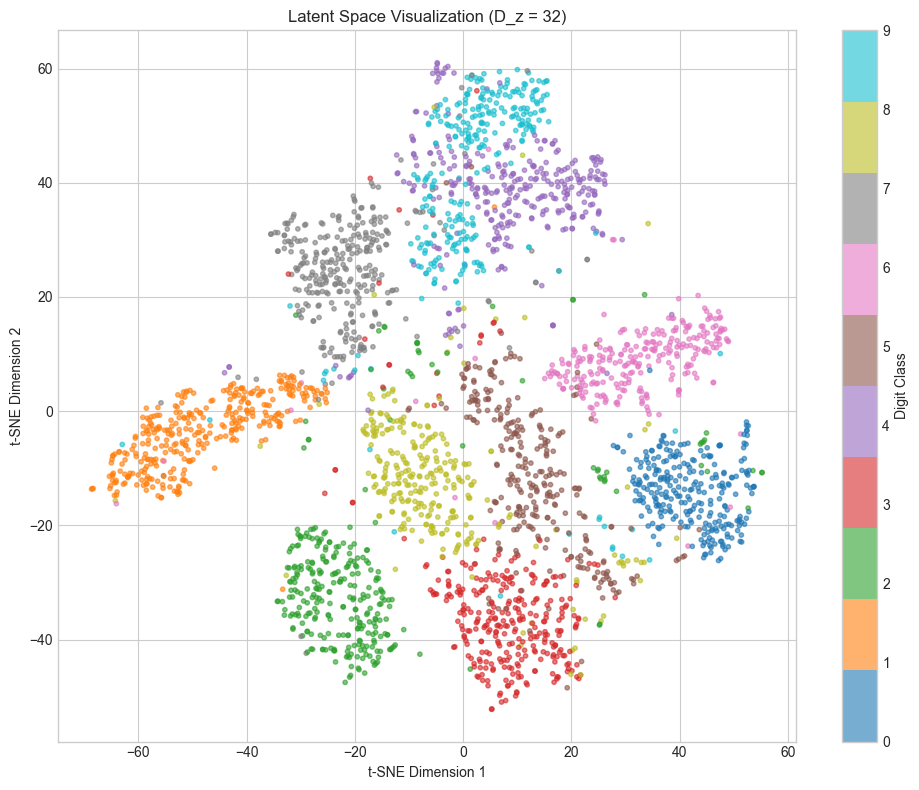

In [20]:
def visualize_latent_space(model, test_loader, device='cpu', n_samples=3000):
    """
    Encode test images and visualize their latent representations using t-SNE.
    """
    from sklearn.manifold import TSNE
    
    model.eval()
    model = model.to(device)
    
    latent_vectors = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            flat_images = images.view(images.size(0), -1).to(device)
            z = model.encode(flat_images)
            latent_vectors.append(z.cpu())
            labels_list.append(labels)
            
            if sum(z.size(0) for z in latent_vectors) >= n_samples:
                break
    
    latent_vectors = torch.cat(latent_vectors, dim=0)[:n_samples]
    labels_all = torch.cat(labels_list, dim=0)[:n_samples]
    
    # Apply t-SNE to reduce to 2D for visualization
    print(f"Applying t-SNE to {latent_vectors.shape[0]} latent vectors of dimension {latent_vectors.shape[1]}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latent_2d = tsne.fit_transform(latent_vectors.numpy())
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                         c=labels_all.numpy(), cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f'Latent Space Visualization (D_z = {latent_vectors.shape[1]})')
    plt.tight_layout()
    plt.show()
    
    return latent_vectors, labels_all

latent_vectors, labels_all = visualize_latent_space(autoencoder, test_loader, device=device)

<span style="font-size: 15px;">

Notice how digits of the same class tend to cluster together in the latent space, even though the autoencoder was trained without any labels! This demonstrates that the encoder has learned meaningful representations that capture the semantic structure of the data.

</span>

### Limitations of Standard Autoencoders

<span style="font-size: 15px;">

While autoencoders are powerful for learning compressed representations, they have a fundamental limitation as generative models: **the latent space is not structured for generation**.

**The Problem: Holes in Latent Space**

If we sample a random vector $z \sim \mathcal{N}(0, I)$ from the latent space and decode it, we often get meaningless outputs:

</span>

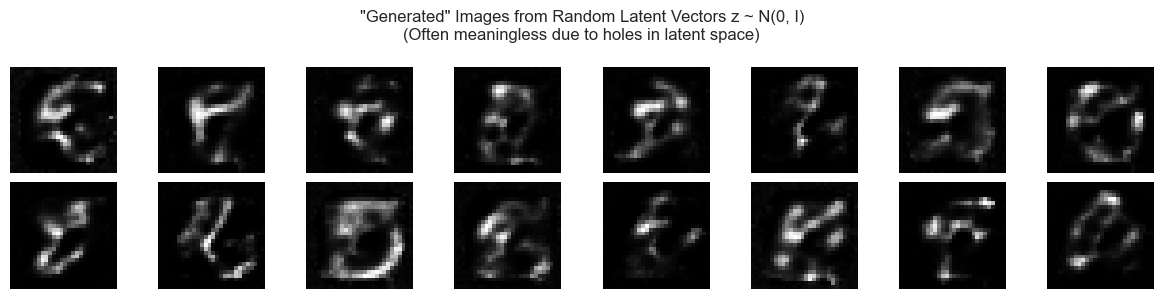

In [21]:
def sample_from_latent_space(model, n_samples=16, latent_dim=32, device='cpu'):
    """
    Sample random latent vectors and decode them.
    This demonstrates why standard autoencoders are NOT generative models.
    """
    model.eval()
    model = model.to(device)
    
    # Sample random latent vectors from N(0, I)
    z_random = torch.randn(n_samples, latent_dim).to(device)
    
    # Decode
    with torch.no_grad():
        generated = model.decode(z_random)
        generated = generated.cpu().view(n_samples, 1, 28, 28)
    
    # Plot
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(n_samples):
        ax = axes[i // 8, i % 8]
        ax.imshow(generated[i].squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.suptitle('"Generated" Images from Random Latent Vectors z ~ N(0, I)\n'
                 '(Often meaningless due to holes in latent space)', fontsize=12)
    plt.tight_layout()
    plt.show()

sample_from_latent_space(autoencoder, n_samples=16, latent_dim=latent_dim, device=device)

<span style="font-size: 15px;">

As you can see, random samples from a standard Gaussian often do not produce recognizable digits. This is because:

1. The autoencoder's latent space is not constrained to follow any particular distribution
2. There are "holes" in the latent space where no training data maps to
3. The decoder has never been trained on latent vectors from these regions

**The Solution: Variational Autoencoders**

The **Variational Autoencoder (VAE)** addresses this limitation by:

1. Forcing the latent space to approximate a known distribution (typically $\mathcal{N}(0, I)$)
2. Learning a probabilistic mapping rather than a deterministic one
3. Adding a regularization term (KL divergence) to the loss function

This will be covered in the next notebook.

</span>

## Summary

<span style="font-size: 15px;">

**Key Takeaways**

1. **Latent Variable Models (LVMs)** provide a unified framework for understanding generative models. They consist of three stages: encoding, latent representation, and decoding.

2. **Autoencoders** are the simplest LVMs, consisting of:
   - An encoder $E_\phi: \mathbb{R}^{D_x} \to \mathbb{R}^{D_z}$ that compresses inputs
   - A decoder $D_\theta: \mathbb{R}^{D_z} \to \mathbb{R}^{D_x}$ that reconstructs inputs

3. **Training is unsupervised**: The loss function is simply the reconstruction error:
   $$\mathcal{L} = \|x - D_\theta(E_\phi(x))\|^2$$

4. **The information bottleneck** ($D_z < D_x$) forces the network to learn meaningful compressed representations.

5. **Standard autoencoders are NOT generative models**: Random samples from the latent space often produce meaningless outputs because the latent space has "holes."

6. **Applications of trained autoencoders**:
   - Dimensionality reduction (alternative to PCA, t-SNE)
   - Feature extraction for downstream tasks
   - Denoising (with denoising autoencoders)
   - Anomaly detection

**What's Next**

In the next notebook, we will introduce the **Variational Autoencoder (VAE)**, which addresses the limitations of standard autoencoders by:
- Learning a probabilistic latent space
- Regularizing the latent space to follow a known distribution
- Enabling true generative capabilities

</span>

### Quick Reference

| Component | Mathematical Form | PyTorch Implementation |
|-----------|-------------------|------------------------|
| Encoder | $z = E_\phi(x)$ | `self.encoder = nn.Sequential(...)` |
| Decoder | $\hat{x} = D_\theta(z)$ | `self.decoder = nn.Sequential(...)` |
| Reconstruction Loss | $\mathcal{L} = \|x - \hat{x}\|^2$ | `nn.MSELoss()` |
| Alternative Loss (BCE) | $-\sum_i [x_i \log \hat{x}_i + (1-x_i)\log(1-\hat{x}_i)]$ | `nn.BCELoss()` |

**Hyperparameters to tune:**
- Latent dimension $D_z$: Larger = more capacity, Smaller = more compression
- Network depth and width: Trade-off between capacity and overfitting
- Learning rate $\gamma$: Typically $10^{-3}$ to $10^{-4}$ for Adam